In [1]:
import matplotlib.pyplot as plt
from isicpy.third_party.pymatreader import hdf5todict
from isicpy.utils import makeFilterCoeffsSOS
from pathlib import Path
import h5py
import numpy as np
import pandas as pd
from scipy import signal

clinc_slines = {
    'S1_S3': 8,
    'S22': 12,
    'S18': 9,
    'S19': 7,
    'S23': 4,
    'S16': 6,
    'S15': 10,
    'S12_S20': 27,
    'S11': 17,
    'S6': 21,
    'S14': 25,
    'S7': 5,
    'S0_S2': 13
    }

clinc_sample_rate = 38690
clinc_sample_interval = pd.Timedelta(clinc_sample_rate ** -1, unit='s')
                                     
clinc_col_names = [key for key, value in clinc_slines.items()]
clinc_indexes = [value for key, value in clinc_slines.items()]

In [2]:
folder_path = Path(r"/users/rdarie/data/rdarie/Neural Recordings/raw/20231109-Phoenix")
file_name = "MB_1699558933_985097_f.mat"
# file_name = "MB_1699560317_650555_f.mat"
# file_name = 'MB_1699560792_657674_f.mat'

file_path = folder_path / file_name
with h5py.File(file_path, 'r') as hdf5_file:
    data = hdf5todict(hdf5_file, variable_names=['data_this_file'], ignore_fields=None)

/gpfs/home/rdarie/isi_analysis/ISI_Analysis_Python/isicpy/third_party/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


In [3]:
print('Intervals between USB packet counts:')
print(np.unique(np.diff(data['data_this_file']['usbPacketCount'].astype(int))))
print('Intervals between sample counts:')
print(np.unique(np.diff(data['data_this_file']['SampleCount'].astype(int))))

Intervals between USB packet counts:
[-65535      0      1]
Intervals between sample counts:
[1]


In [4]:
clinc_index = pd.timedelta_range(
        start=0, periods=data['data_this_file']['ChannelData'].shape[0],
        freq=clinc_sample_interval)
clinc_data = pd.DataFrame(
    data['data_this_file']['ChannelData'][:, clinc_indexes] * 0.195,  # 0.195 uV/count
    index=clinc_index, columns=clinc_col_names)
clinc_sync_wave = pd.DataFrame(
        data['data_this_file']['SyncWave'].reshape(-1, 1),
        index=clinc_index, columns=['sync_wave'])

In [5]:
rising_edge_mask = ((clinc_sync_wave['sync_wave'] == 0) & (clinc_sync_wave['sync_wave'].shift(1) == 1))
falling_edge_mask = ((clinc_sync_wave['sync_wave'] == 1) & (clinc_sync_wave['sync_wave'].shift(1) == 0))
any_edge_mask = rising_edge_mask | falling_edge_mask

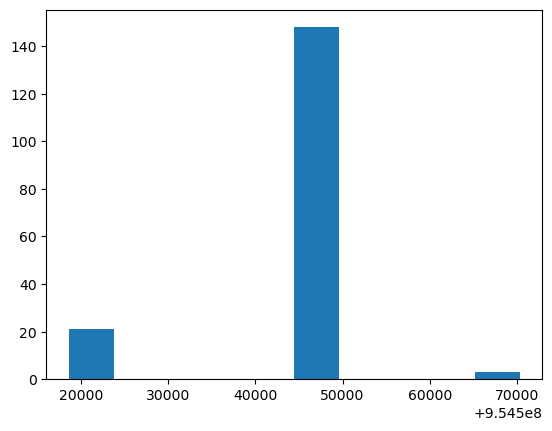

In [6]:
edge_intervals = np.diff(clinc_index[any_edge_mask])
around_one_mask = edge_intervals < np.asarray(int(1.5e9), dtype=np.timedelta64)
plt.hist(edge_intervals[around_one_mask].astype(int))
plt.show()

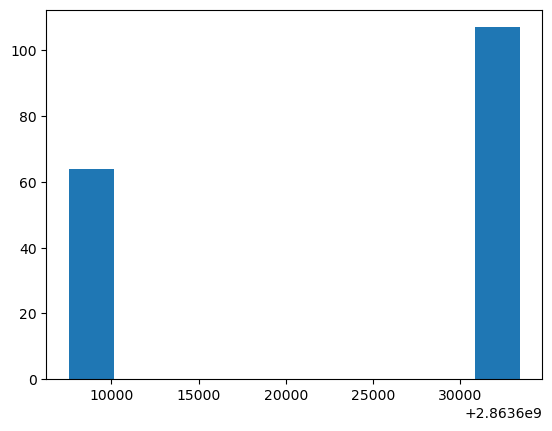

In [7]:
rising_intervals = np.diff(clinc_index[rising_edge_mask])
plt.hist(rising_intervals.astype(int))
plt.show()

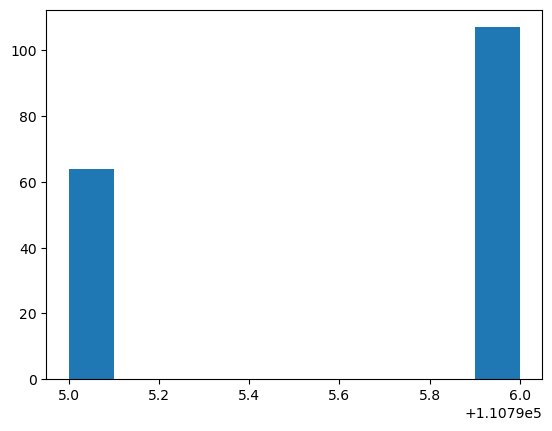

In [8]:
sample_index = np.arange(0, data['data_this_file']['ChannelData'].shape[0])
rising_intervals_samples = np.diff(sample_index[rising_edge_mask])
plt.hist(rising_intervals_samples.astype(int))
plt.show()

In [9]:
np.unique(rising_intervals)

array([2863607570, 2863633416], dtype='timedelta64[ns]')

In [10]:
print(rising_intervals.sum())
print((rising_edge_mask.sum() - 1) * 3)

489679659992 nanoseconds
513
